In [1]:
import requests
import numpy as np
import pandas as pd
import pandas_profiling
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
import statsmodels.api as sm # Provides cross-sectional models and methods
from statsmodels.graphics.api import abline_plot # Plots line given intercept and slope
from sklearn.metrics import mean_squared_error, r2_score # Rates how close regression line is to data
from sklearn.model_selection import train_test_split #  Splits data into training and test groups
from sklearn import linear_model, preprocessing # Ordinary least square regression and standardizes the data
import warnings # For handling error messages.

In [3]:
os.chdir(r'C:\Users\2bogu\Desktop\Sringboard_Materials\capstone2\data\interim')

df = pd.read_csv('iter_drop')

In [4]:
df.shape

(26863, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26863 entries, 0 to 26862
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CONTRACT DATE           26863 non-null  object 
 1   SETUP DATE              26863 non-null  object 
 2   ORIGINAL LOAN AMOUNT    26863 non-null  float64
 3   ORIGINAL TERM           26863 non-null  int64  
 4   ORIGINAL MATURITY DATE  26863 non-null  object 
 5   CURRENT MATURITY DATE   26863 non-null  object 
 6   INTEREST RATE           26863 non-null  float64
 7   DEBT TO INCOME          26863 non-null  float64
 8   PAYMENT AMOUNT          26863 non-null  float64
 9   TOTAL INTEREST PAID     26863 non-null  float64
 10  SUCCESSOR NUMBER        26863 non-null  object 
 11  ACCOUNT CODE            26863 non-null  object 
 12  ACCOUNT CODE DATE       26863 non-null  object 
 13  CANCEL REASON           26863 non-null  object 
 14  TYPE OF BANKRUPTCY      26863 non-null

In [6]:
# CONVERTING TO DATETIOME OBJECTS
df['CONTRACT DATE'] = pd.to_datetime(df['CONTRACT DATE'], format="%m/%d/%Y")
df['SETUP DATE'] = pd.to_datetime(df['SETUP DATE'], format="%m/%d/%Y")
df['ORIGINAL MATURITY DATE'] = pd.to_datetime(df['ORIGINAL MATURITY DATE'], format="%m/%d/%Y")
df['CURRENT MATURITY DATE'] = pd.to_datetime(df['CURRENT MATURITY DATE'], format="%m/%d/%Y")
df['ACCOUNT CODE DATE'] = pd.to_datetime(df['ACCOUNT CODE DATE'], format="%m/%d/%Y")

In [7]:
# adds difference in original and current maturity date coulmn
# pos value means ahead, neg = behind
df['MATURITY DIFFERENCE'] = (df['ORIGINAL MATURITY DATE'] - df['CURRENT MATURITY DATE']).astype('timedelta64[M]')

In [8]:
# filters out loans less than a year old
df = df[(df['CONTRACT DATE'] < '09-01-2019')]

In [9]:
df.describe()

ORIGINAL LOAN AMOUNT  ORIGINAL TERM  INTEREST RATE  DEBT TO INCOME  \
count          25217.000000   25217.000000   25217.000000    25217.000000   
mean           11716.110679     168.805449       3.833221        0.318712   
std             6702.978595      31.273135       0.996224        0.288712   
min              701.000000      60.000000       2.990000        0.000000   
25%             6144.000000     180.000000       3.490000        0.190000   
50%            10519.000000     180.000000       3.490000        0.300000   
75%            16252.000000     180.000000       3.490000        0.430000   
max            25000.000000     180.000000       8.490000       36.090000   

       PAYMENT AMOUNT  TOTAL INTEREST PAID  Payments Made  num_borrowers  \
count    25217.000000         25217.000000   25217.000000   25217.000000   
mean        92.225118          1403.062991      70.531740       1.455764   
std         53.333301          1018.421520      49.839801       0.498049   
min          5.000000           -99.000000       0.000000       1.000000   
25%         50.000000           571.000000      40.000000       1.000000   
50%         84.000000          1186.000000      55.000000       1.000000   
75%        128.000000          2058.000000      83.000000       2.000000   
max        455.000000          6317.000000     180.000000       2.000000   

       avg_credit_score  MATURITY DIFFERENCE  
count      25217.000000         25217.000000  
mean         735.228635            22.306856  
std           53.517555            52.409994  
min          512.000000          -122.000000  
25%          700.000000            -2.000000  
50%          746.500000             0.000000  
75%          779.500000             1.000000  
max          833.000000           179.000000

In [10]:
# drops crazy outlier
df.drop(df['DEBT TO INCOME'].idxmax(), inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25216 entries, 0 to 26862
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CONTRACT DATE           25216 non-null  datetime64[ns]
 1   SETUP DATE              25216 non-null  datetime64[ns]
 2   ORIGINAL LOAN AMOUNT    25216 non-null  float64       
 3   ORIGINAL TERM           25216 non-null  int64         
 4   ORIGINAL MATURITY DATE  25216 non-null  datetime64[ns]
 5   CURRENT MATURITY DATE   25216 non-null  datetime64[ns]
 6   INTEREST RATE           25216 non-null  float64       
 7   DEBT TO INCOME          25216 non-null  float64       
 8   PAYMENT AMOUNT          25216 non-null  float64       
 9   TOTAL INTEREST PAID     25216 non-null  float64       
 10  SUCCESSOR NUMBER        25216 non-null  object        
 11  ACCOUNT CODE            25216 non-null  object        
 12  ACCOUNT CODE DATE       25216 non-null  dateti

In [12]:
# Converting num_borrowers into catagorical data to get dummies
df.num_borrowers = df.num_borrowers.astype(str)


In [13]:
# converts to floats
df = df.select_dtypes(include=['object', 'datetime']).join(df.select_dtypes(exclude=['object', 'datetime']).astype('float64')) 
#df_dum = df_dum.select_dtypes(include=['object', 'datetime']).join(df_dum.select_dtypes(exclude=['object', 'datetime']).astype('float64'))

array([[<AxesSubplot:title={'center':'ORIGINAL LOAN AMOUNT'}>,
        <AxesSubplot:title={'center':'ORIGINAL TERM'}>,
        <AxesSubplot:title={'center':'INTEREST RATE'}>],
       [<AxesSubplot:title={'center':'DEBT TO INCOME'}>,
        <AxesSubplot:title={'center':'PAYMENT AMOUNT'}>,
        <AxesSubplot:title={'center':'TOTAL INTEREST PAID'}>],
       [<AxesSubplot:title={'center':'Payments Made'}>,
        <AxesSubplot:title={'center':'avg_credit_score'}>,
        <AxesSubplot:title={'center':'MATURITY DIFFERENCE'}>]],
      dtype=object)

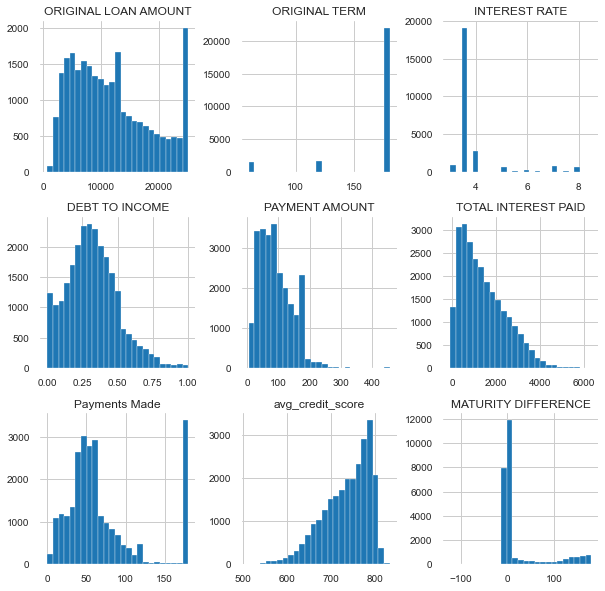

In [14]:
df.select_dtypes(exclude='object').hist(bins=25, figsize=(10,10))

In [15]:
dft = (df.drop(df.select_dtypes(include=['datetime', 'object']), axis=1)).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25216 entries, 0 to 26862
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ORIGINAL LOAN AMOUNT  25216 non-null  float64
 1   ORIGINAL TERM         25216 non-null  float64
 2   INTEREST RATE         25216 non-null  float64
 3   DEBT TO INCOME        25216 non-null  float64
 4   PAYMENT AMOUNT        25216 non-null  float64
 5   TOTAL INTEREST PAID   25216 non-null  float64
 6   Payments Made         25216 non-null  float64
 7   avg_credit_score      25216 non-null  float64
 8   MATURITY DIFFERENCE   25216 non-null  float64
dtypes: float64(9)
memory usage: 2.5 MB


In [16]:
#sns.pairplot(df, hue='Purpose')

In [17]:
#sns.pairplot(df, hue='Loan Type')

<AxesSubplot:>

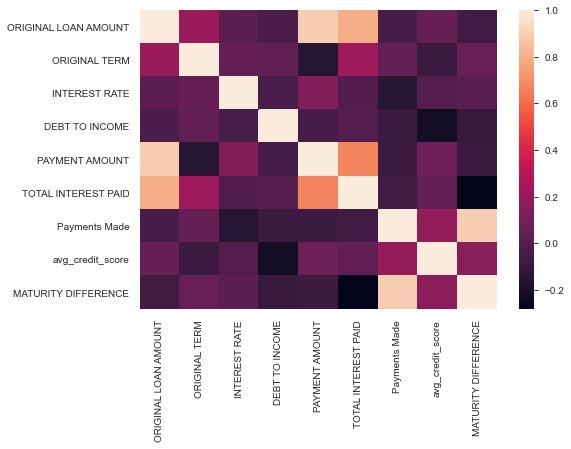

In [18]:
sns.heatmap(df.corr())

<AxesSubplot:xlabel='Payments Made', ylabel='MATURITY DIFFERENCE'>

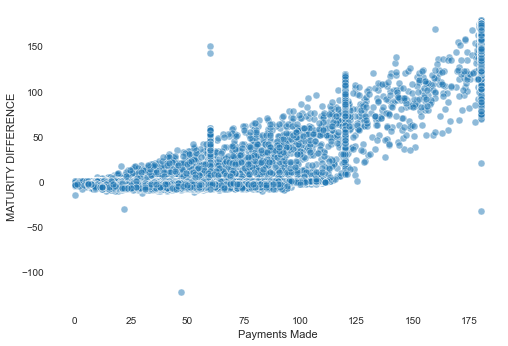

In [19]:
sns.scatterplot(x='Payments Made', y='MATURITY DIFFERENCE', data=df, alpha=0.5)

<AxesSubplot:xlabel='Payments Made', ylabel='MATURITY DIFFERENCE'>

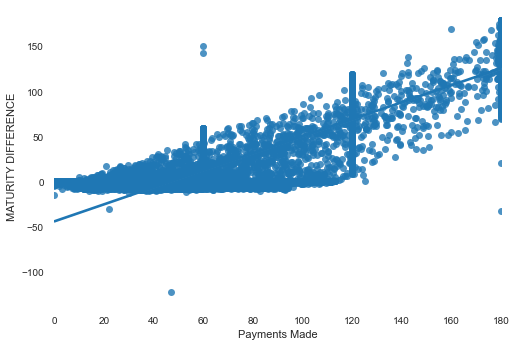

In [20]:
sns.regplot(x='Payments Made', y='MATURITY DIFFERENCE', data=df)

In [21]:
## Find stories in the dataw/ plots, lots of plots
## Then comes statistical inference to find the the relationships are real
## Then ML

In [22]:
df.columns

Index(['CONTRACT DATE', 'SETUP DATE', 'ORIGINAL MATURITY DATE',
       'CURRENT MATURITY DATE', 'SUCCESSOR NUMBER', 'ACCOUNT CODE',
       'ACCOUNT CODE DATE', 'CANCEL REASON', 'TYPE OF BANKRUPTCY', 'Purpose',
       'Loan Type', 'Underwriting', 'Pledged', 'num_borrowers',
       'ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 'INTEREST RATE',
       'DEBT TO INCOME', 'PAYMENT AMOUNT', 'TOTAL INTEREST PAID',
       'Payments Made', 'avg_credit_score', 'MATURITY DIFFERENCE'],
      dtype='object')

<AxesSubplot:xlabel='Purpose', ylabel='DEBT TO INCOME'>

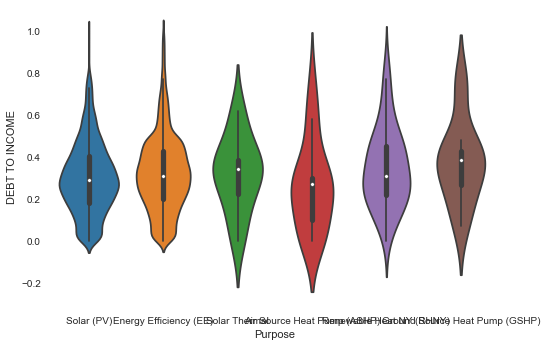

In [23]:
sns.violinplot(x='Purpose', y='DEBT TO INCOME', data=df)

<AxesSubplot:xlabel='Purpose', ylabel='avg_credit_score'>

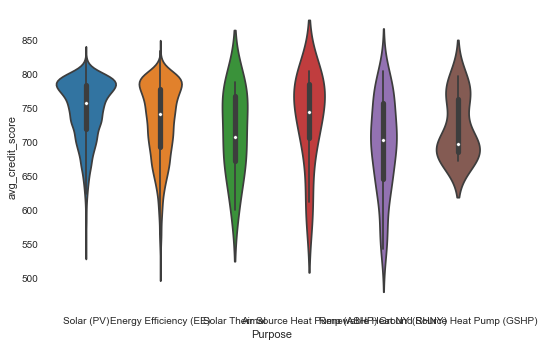

In [24]:
sns.violinplot(x='Purpose', y='avg_credit_score', data=df)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='avg_credit_score'>

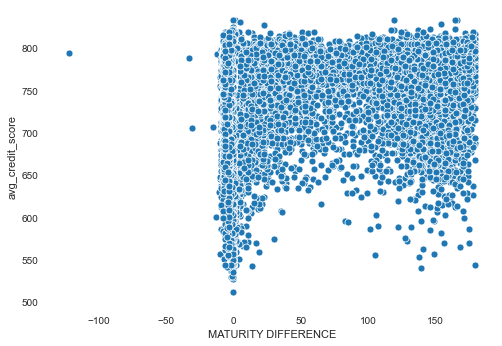

In [25]:
sns.scatterplot(x='MATURITY DIFFERENCE', y='avg_credit_score', data=df)

<AxesSubplot:xlabel='avg_credit_score', ylabel='ACCOUNT CODE'>

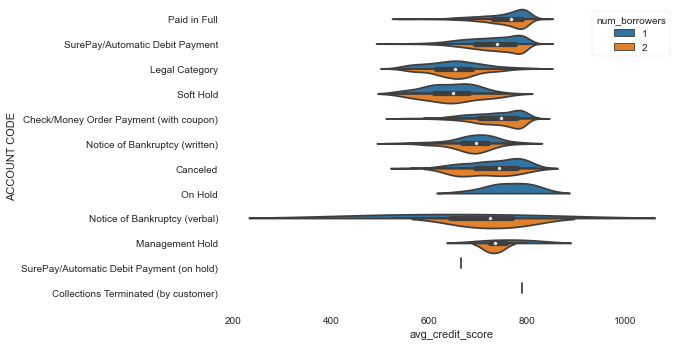

In [26]:
sns.violinplot(x='avg_credit_score', y='ACCOUNT CODE', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='ACCOUNT CODE'>

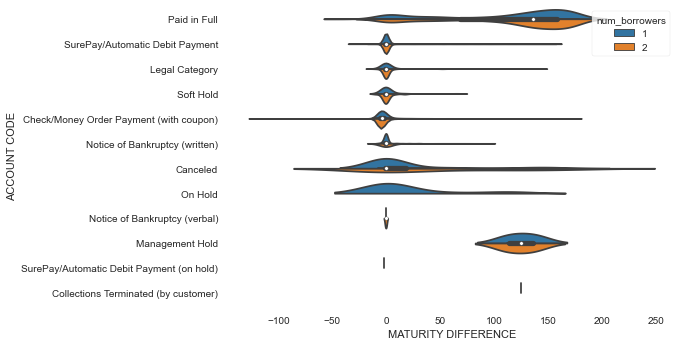

In [27]:
sns.violinplot(x='MATURITY DIFFERENCE', y='ACCOUNT CODE', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='ACCOUNT CODE'>

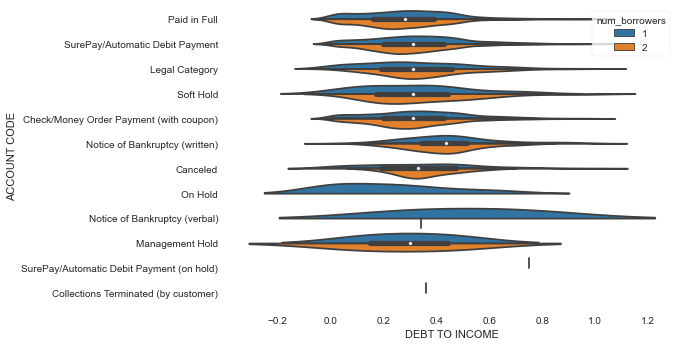

In [28]:
sns.violinplot(x='DEBT TO INCOME', y='ACCOUNT CODE', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='ACCOUNT CODE'>

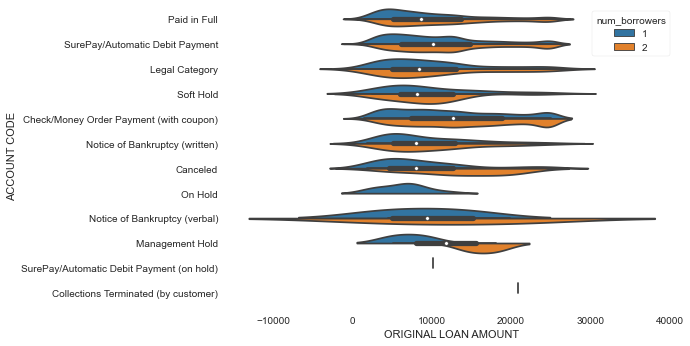

In [29]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='ACCOUNT CODE', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='PAYMENT AMOUNT', ylabel='ACCOUNT CODE'>

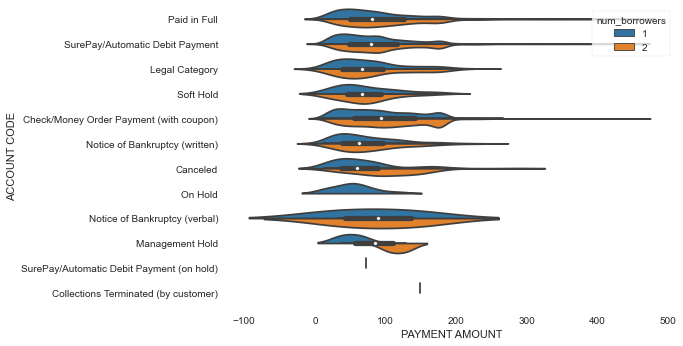

In [30]:
sns.violinplot(x='PAYMENT AMOUNT', y='ACCOUNT CODE', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='Payments Made', ylabel='ACCOUNT CODE'>

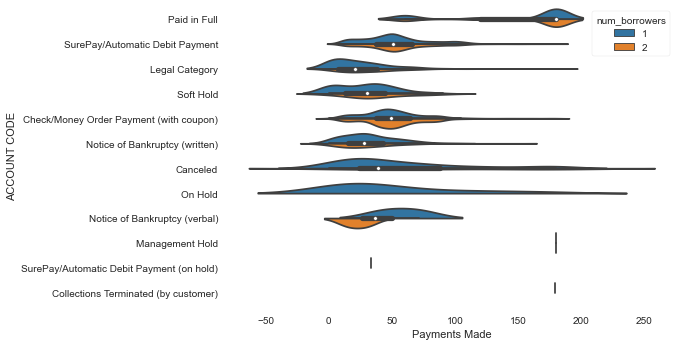

In [103]:
sns.violinplot(x='Payments Made', y='ACCOUNT CODE', data=df, hue='num_borrowers', scale='count', split=True)

In [32]:
# create column to sort accounts in good standing from accounts in bad standing
df['bad'] = df['ACCOUNT CODE'].str.contains('Hold|Canceled|Terminated|Bankruptcy', regex=True)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='Purpose'>

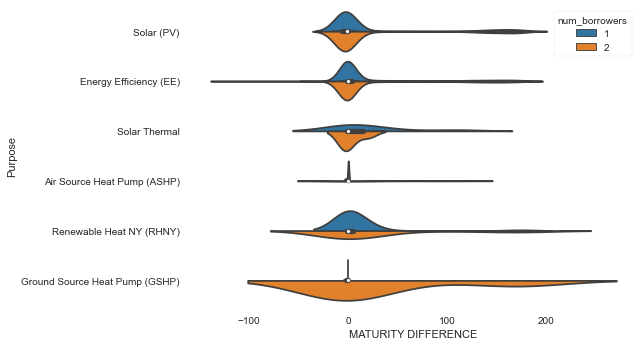

In [33]:
sns.violinplot(x='MATURITY DIFFERENCE', y='Purpose', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='avg_credit_score', ylabel='Purpose'>

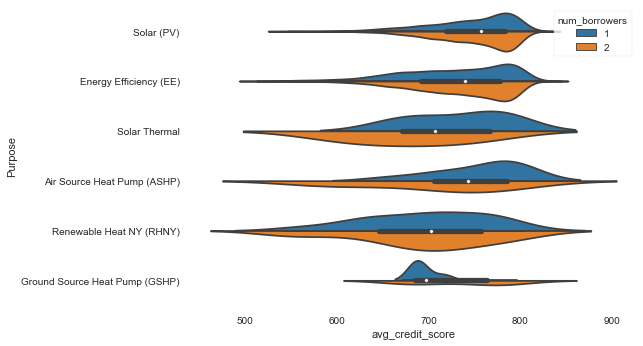

In [34]:
sns.violinplot(x='avg_credit_score', y='Purpose', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='Purpose'>

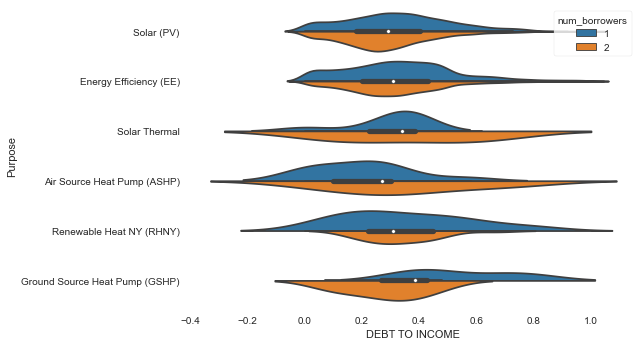

In [101]:
sns.violinplot(x='DEBT TO INCOME', y='Purpose', data=df, hue='num_borrowers', scale='count', split=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Purpose'>

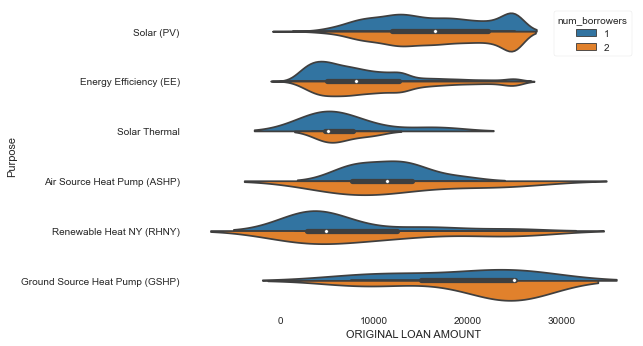

In [100]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Purpose', data=df, hue='num_borrowers', scale='count', split=True)

<AxesSubplot:xlabel='PAYMENT AMOUNT', ylabel='Purpose'>

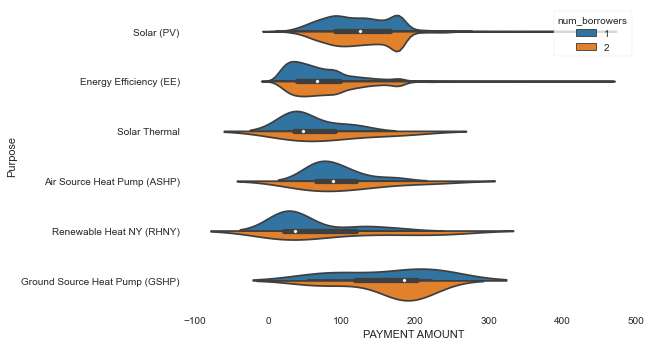

In [37]:
sns.violinplot(x='PAYMENT AMOUNT', y='Purpose', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='Payments Made', ylabel='Purpose'>

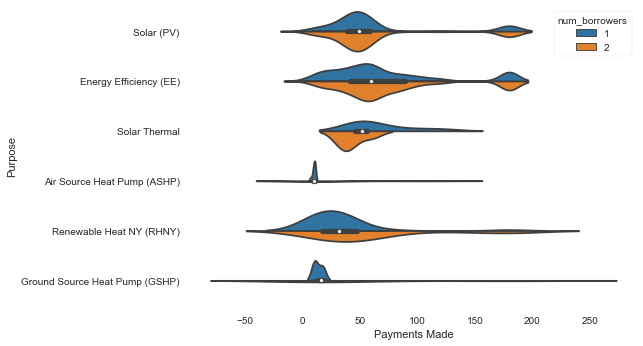

In [38]:
sns.violinplot(x='Payments Made', y='Purpose', data=df, hue='num_borrowers', split=True)

In [39]:
df.columns

Index(['CONTRACT DATE', 'SETUP DATE', 'ORIGINAL MATURITY DATE',
       'CURRENT MATURITY DATE', 'SUCCESSOR NUMBER', 'ACCOUNT CODE',
       'ACCOUNT CODE DATE', 'CANCEL REASON', 'TYPE OF BANKRUPTCY', 'Purpose',
       'Loan Type', 'Underwriting', 'Pledged', 'num_borrowers',
       'ORIGINAL LOAN AMOUNT', 'ORIGINAL TERM', 'INTEREST RATE',
       'DEBT TO INCOME', 'PAYMENT AMOUNT', 'TOTAL INTEREST PAID',
       'Payments Made', 'avg_credit_score', 'MATURITY DIFFERENCE', 'bad'],
      dtype='object')

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Pledged'>

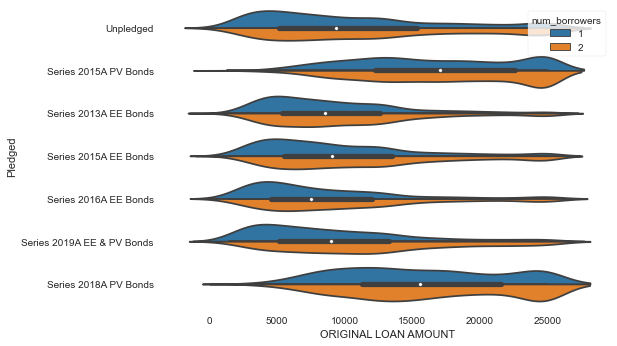

In [40]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Pledged', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='Pledged'>

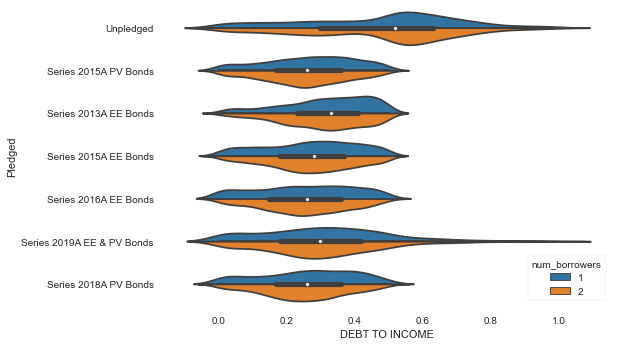

In [41]:
sns.violinplot(x='DEBT TO INCOME', y='Pledged', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='avg_credit_score', ylabel='Pledged'>

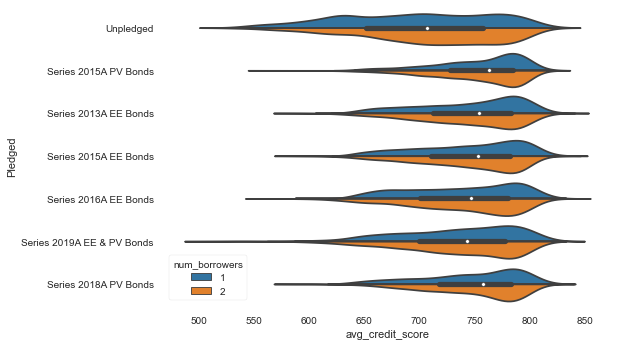

In [42]:
sns.violinplot(x='avg_credit_score', y='Pledged', data=df, hue='num_borrowers', split=True)

In [43]:
# create column to sort accounts in good standing from accounts in bad standing
df['bad'] = df['ACCOUNT CODE'].str.contains('Hold|Canceled|Terminated|Bankruptcy', regex=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Purpose'>

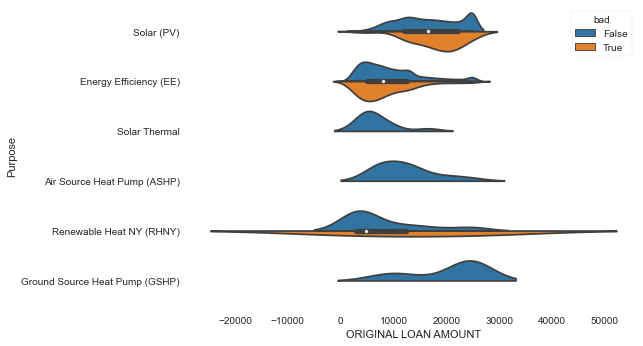

In [44]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Purpose', data=df, hue='bad', split=True)

<AxesSubplot:xlabel='avg_credit_score', ylabel='Purpose'>

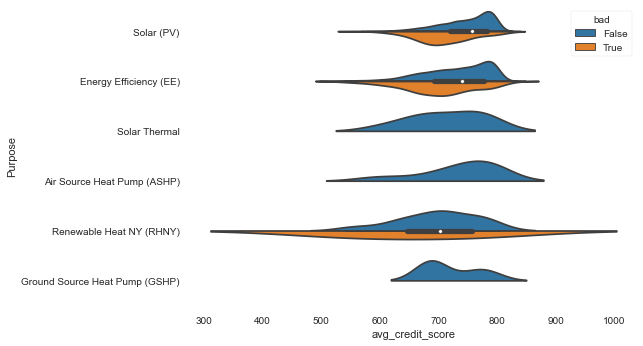

In [45]:
sns.violinplot(x='avg_credit_score', y='Purpose', data=df, hue='bad', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='Purpose'>

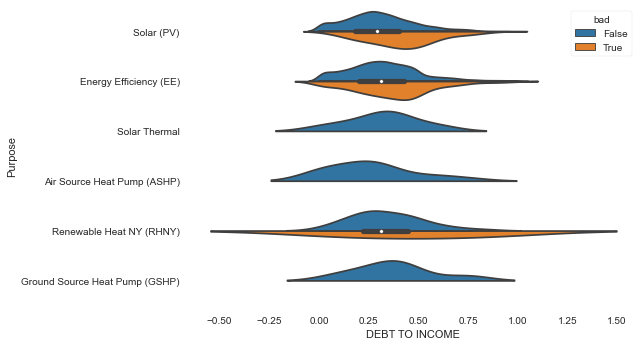

In [46]:
sns.violinplot(x='DEBT TO INCOME', y='Purpose', data=df, hue='bad', split=True)

In [47]:
# It appears lower credit scores w/ higher debt to income ratios are seeking larger loans and going bad more often

In [48]:
df['behind'] = df['MATURITY DIFFERENCE'] < 0

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Purpose'>

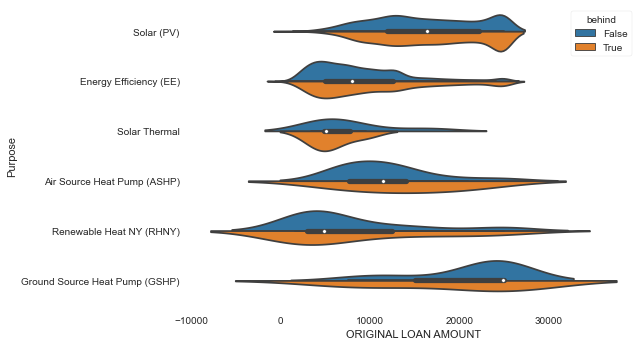

In [49]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Purpose', data=df, hue='behind', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='Purpose'>

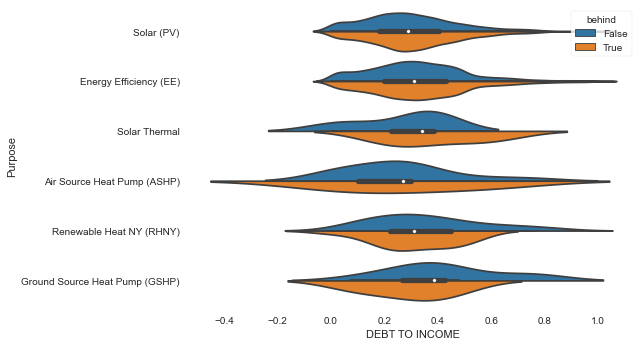

In [50]:
sns.violinplot(x='DEBT TO INCOME', y='Purpose', data=df, hue='behind', split=True)

<AxesSubplot:xlabel='avg_credit_score', ylabel='Purpose'>

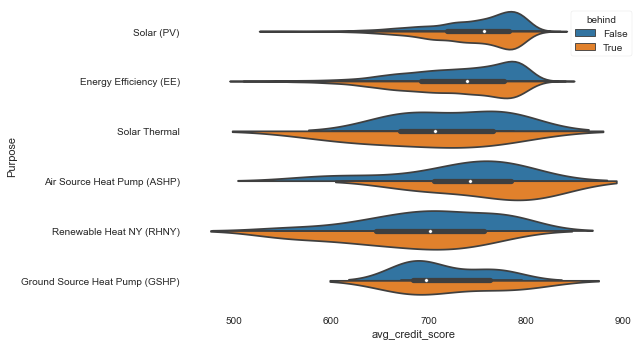

In [51]:
sns.violinplot(x='avg_credit_score', y='Purpose', data=df, hue='behind', split=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='avg_credit_score'>

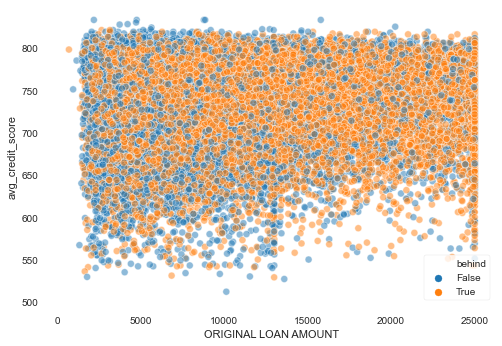

In [52]:
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='avg_credit_score', data=df, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='bad', ylabel='DEBT TO INCOME'>

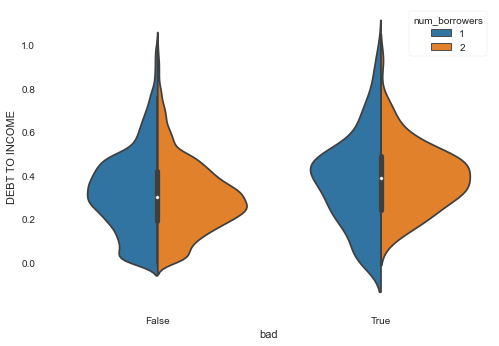

In [53]:
sns.violinplot(x='bad', y='DEBT TO INCOME', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='bad', ylabel='avg_credit_score'>

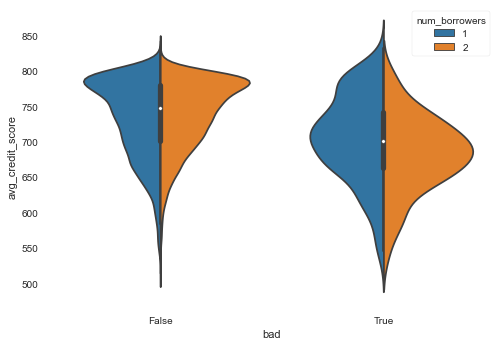

In [54]:
sns.violinplot(x='bad', y='avg_credit_score', data=df, hue='num_borrowers', split=True)

<AxesSubplot:xlabel='bad', ylabel='ORIGINAL LOAN AMOUNT'>

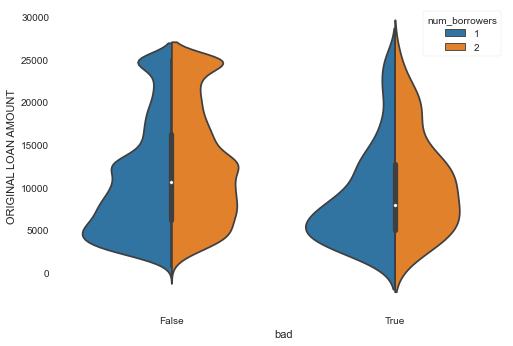

In [55]:
sns.violinplot(x='bad', y='ORIGINAL LOAN AMOUNT', data=df, hue='num_borrowers', split=True)

In [56]:
df['paid'] = df['ACCOUNT CODE'].str.contains('Paid in Full')

<AxesSubplot:xlabel='avg_credit_score', ylabel='Purpose'>

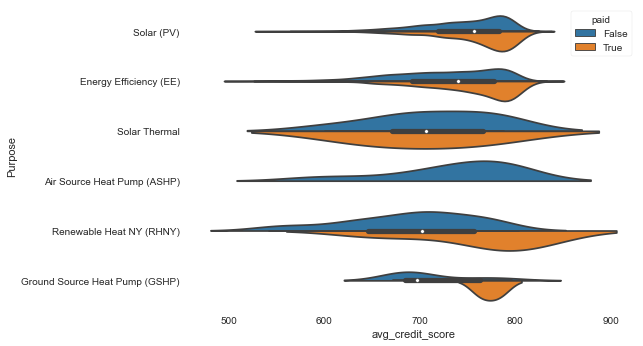

In [57]:
sns.violinplot(x='avg_credit_score', y='Purpose', data=df, hue='paid', split=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Purpose'>

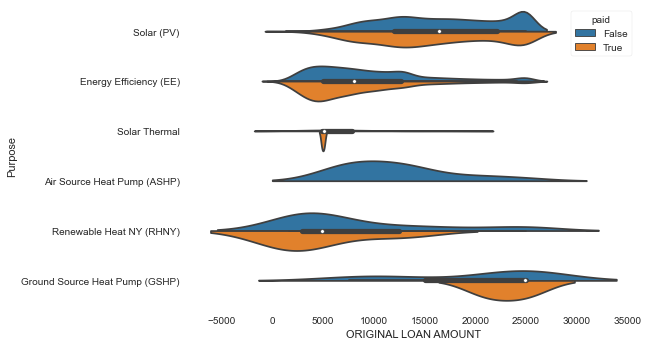

In [58]:
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Purpose', data=df, hue='paid', split=True)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='avg_credit_score'>

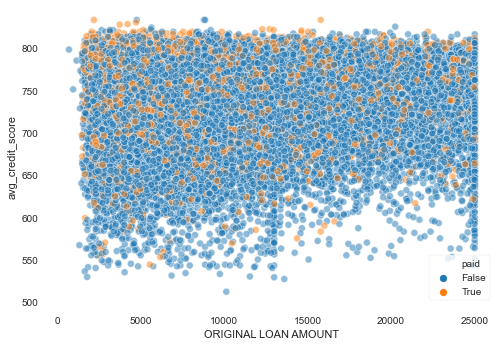

In [59]:
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='avg_credit_score', data=df, hue='paid', alpha=0.5)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='Purpose'>

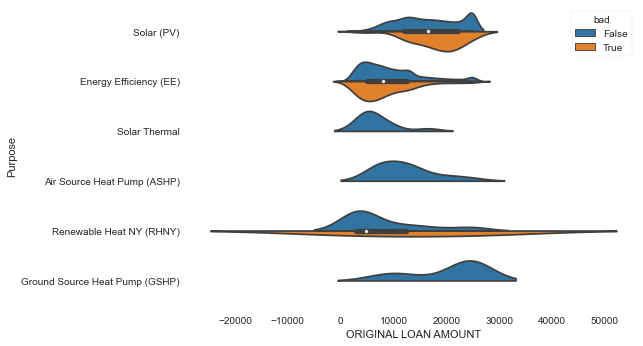

In [60]:
# Two loan types responsible for most loans in bad standing
sns.violinplot(x='ORIGINAL LOAN AMOUNT', y='Purpose', data=df, hue='bad', split=True)

<AxesSubplot:xlabel='avg_credit_score', ylabel='Purpose'>

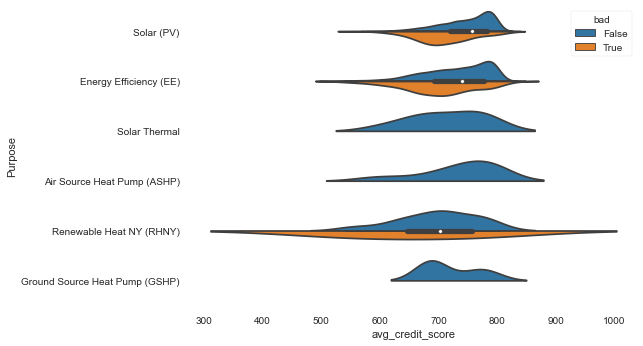

In [61]:
sns.violinplot(x='avg_credit_score', y='Purpose', data=df, hue='bad', split=True)

<AxesSubplot:xlabel='DEBT TO INCOME', ylabel='Purpose'>

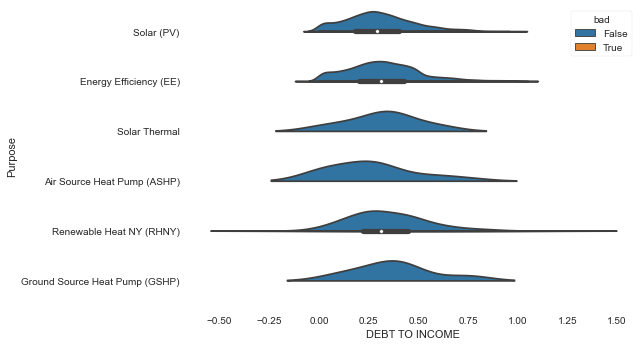

In [98]:
sns.violinplot(x='DEBT TO INCOME', y='Purpose', data=df, hue='bad', scale='count', split=True)

In [63]:
df_has_bad = df[df['Purpose'].isin(['Solar (PV)', 'Energy Efficiency (EE)', 'Renewable Heat NY (RHNY)'])]

In [64]:
df_no_bad = df[~df['Purpose'].isin(['Solar (PV)', 'Energy Efficiency (EE)', 'Renewable Heat NY (RHNY)'])]
df_no_bad.count()

CONTRACT DATE             42
SETUP DATE                42
ORIGINAL MATURITY DATE    42
CURRENT MATURITY DATE     42
SUCCESSOR NUMBER          42
ACCOUNT CODE              42
ACCOUNT CODE DATE         42
CANCEL REASON             42
TYPE OF BANKRUPTCY        42
Purpose                   42
Loan Type                 42
Underwriting              42
Pledged                   42
num_borrowers             42
ORIGINAL LOAN AMOUNT      42
ORIGINAL TERM             42
INTEREST RATE             42
DEBT TO INCOME            42
PAYMENT AMOUNT            42
TOTAL INTEREST PAID       42
Payments Made             42
avg_credit_score          42
MATURITY DIFFERENCE       42
bad                       42
behind                    42
paid                      42
dtype: int64

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='avg_credit_score'>

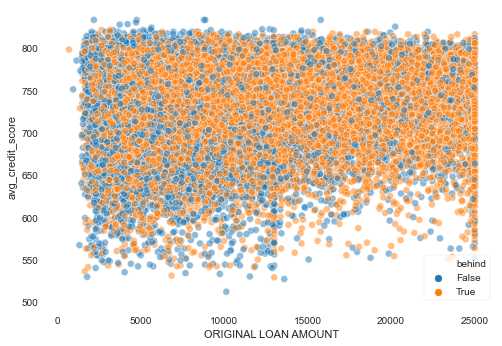

In [65]:
# the larger the loan the more likely it is to fall behind, regardless of credit score
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='avg_credit_score', data=df_has_bad, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='avg_credit_score'>

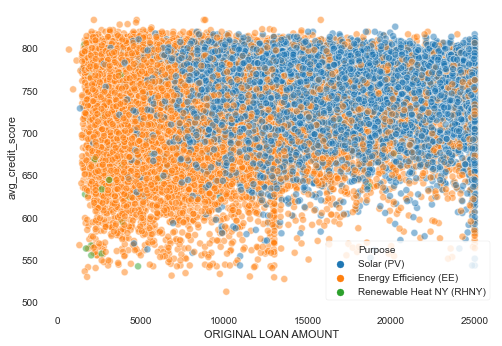

In [66]:
# the larger the loan the more likely it is to fall behind, regardless of credit score
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='avg_credit_score', data=df_has_bad, hue='Purpose', alpha=0.5)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='DEBT TO INCOME'>

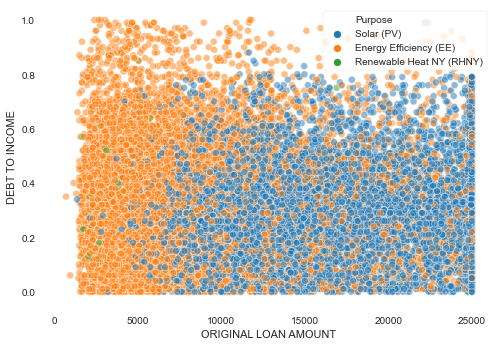

In [67]:
# the larger the loan the more likely it is to fall behind, regardless of credit score
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='DEBT TO INCOME', data=df_has_bad, hue='Purpose', alpha=0.5)

<AxesSubplot:xlabel='ORIGINAL LOAN AMOUNT', ylabel='avg_credit_score'>

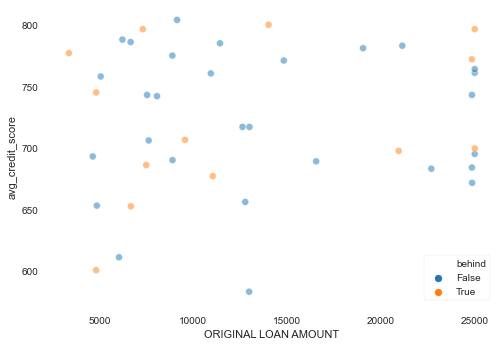

In [68]:
# Three loan purposes account for the majority of loans
sns.scatterplot(x='ORIGINAL LOAN AMOUNT', y='avg_credit_score', data=df_no_bad, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='avg_credit_score'>

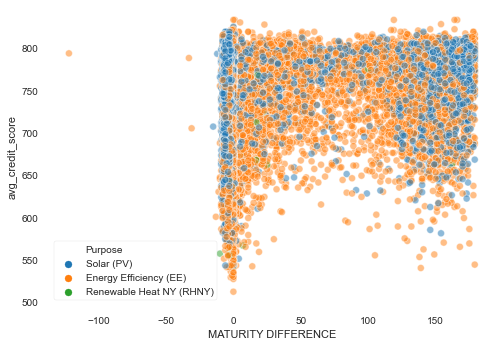

In [69]:
sns.scatterplot(x='MATURITY DIFFERENCE', y='avg_credit_score', data=df_has_bad, hue='Purpose', alpha=0.5)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='avg_credit_score'>

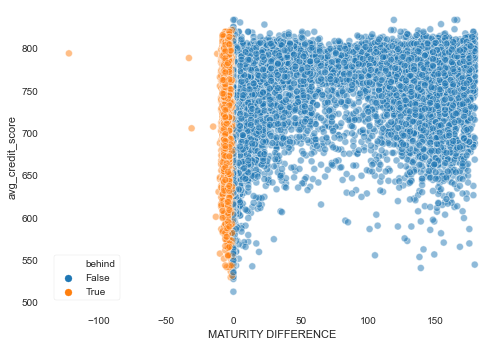

In [70]:
# the larger the loan the more likely it is to fall behind, regardless of credit score
sns.scatterplot(x='MATURITY DIFFERENCE', y='avg_credit_score', data=df_has_bad, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='MATURITY DIFFERENCE', ylabel='avg_credit_score'>

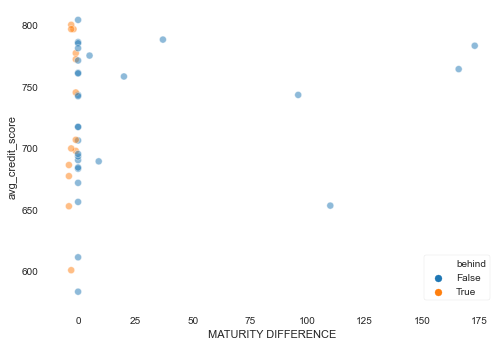

In [71]:
# the larger the loan the more likely it is to fall behind, regardless of credit score
sns.scatterplot(x='MATURITY DIFFERENCE', y='avg_credit_score', data=df_no_bad, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='PAYMENT AMOUNT', ylabel='avg_credit_score'>

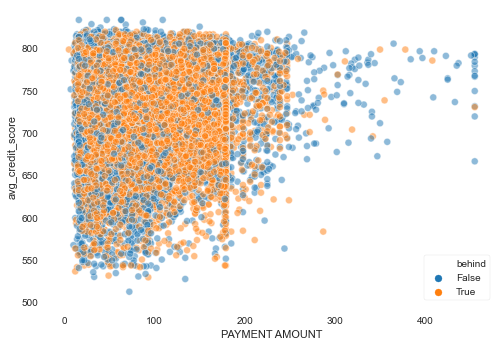

In [72]:
sns.scatterplot(x='PAYMENT AMOUNT', y='avg_credit_score', data=df_has_bad, hue='behind', alpha=0.5)

<AxesSubplot:xlabel='PAYMENT AMOUNT', ylabel='avg_credit_score'>

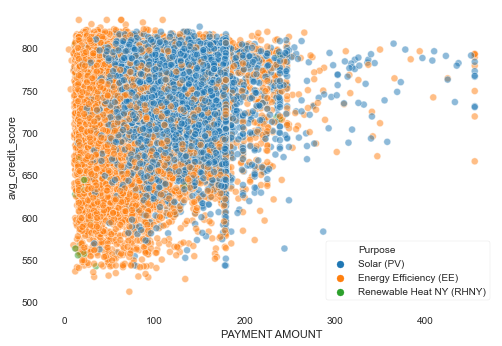

In [73]:
sns.scatterplot(x='PAYMENT AMOUNT', y='avg_credit_score', data=df_has_bad, hue='Purpose', alpha=0.5)

In [74]:
df.Purpose.unique()

array(['Solar (PV)', 'Energy Efficiency (EE)', 'Solar Thermal',
       'Air Source Heat Pump (ASHP)', 'Renewable Heat NY (RHNY)',
       'Ground Source Heat Pump (GSHP)'], dtype=object)

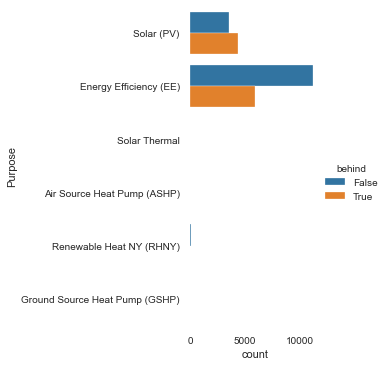

In [105]:
sns.catplot(y='Purpose', data=df, kind='count', hue='behind')

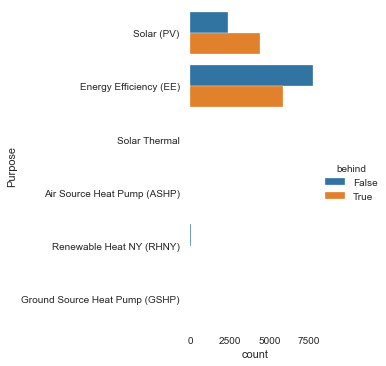

In [108]:
df_not_paid_off = df[df['ACCOUNT CODE'] != 'Paid in Full']
sns.catplot(y='Purpose', data=df_not_paid_off, kind='count', hue='behind')

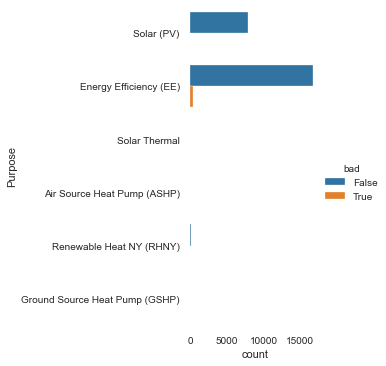

In [97]:
sns.catplot(y='Purpose', data=df, kind='count', hue='bad')

In [99]:
sum(df.bad)

412

<AxesSubplot:>

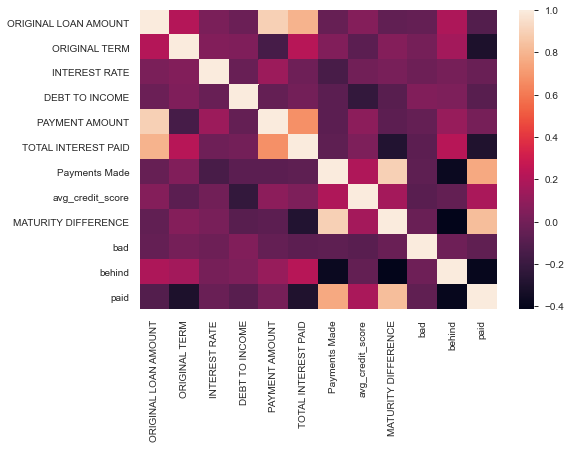

In [104]:
sns.heatmap(df.corr())

# Conclusions

- Majority of loans are for two purposes: Solar and Energy Effiencency
- Extreamly low amount of 'bad' loans
- Around half of loans that are not paid off are behind (COVID?)
- The higher theoriginal loan amount the more likely the loan is to be behind